# Importing libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121
#from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import keras
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2

import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
main_path = "/content/drive/My Drive/chest_xray1/"

In [4]:
train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")
val_path=os.path.join(main_path,"val")

In [5]:
pneumonia_train_images = glob.glob(train_path+"/PNEUMONIA/*.jpeg")
normal_train_images = glob.glob(train_path+"/NORMAL/*.jpeg")

In [6]:
data = pd.DataFrame(np.concatenate([[0]*len(normal_train_images) , [1] *  len(pneumonia_train_images)]),columns=["class"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


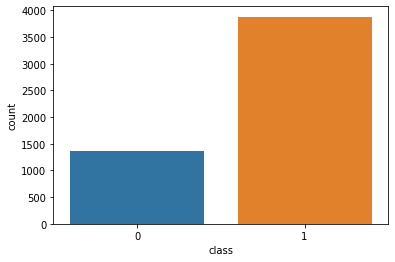

In [7]:
sns.countplot(data['class'],data=data)

### Clear imbalance between normal and pneumonia class

# Defining Image Generators
1. Using **ImageDataGenerator** , to augment our images so as to create a larger dataset for our model to train on.
2. Also to deal with the imbalanced number of data points of the given classes

In [8]:
# define the type of augmentation techniques we will apply.
train_Datagen = ImageDataGenerator(
    rescale =1/255,
    #shear_range=10,
    zoom_range = 0.2,
    #horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
#     rotation_range=20,
    fill_mode = 'nearest',
)
val_datagen = ImageDataGenerator(
    rescale = 1/255
)

# Defining model
* Using pre-trained VGG-16 model.
* Freezing all the layers of model to train.
* Using RMSProp as optimiser
* Also  using learning rate decay to optimize the learning process.

In [9]:
conv_base = DenseNet121(include_top = False,weights='imagenet')
for i in conv_base.layers:
    i.trainable=False
X = conv_base.output
X = keras.layers.GlobalAveragePooling2D()(X)
X = keras.layers.Dense(128,activation='relu')(X)
predictions = keras.layers.Dense(1,activation='sigmoid')(X)
model= keras.Model(conv_base.input,predictions)
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.RMSprop(lr_schedule),
             metrics=['accuracy'])

29097984/29084464 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                           

### Creating augmented data from the above defined image data generators

In [23]:
train_generator=train_Datagen.flow_from_directory(
    train_path,
    target_size=(150,150),
    batch_size= 32,
    class_mode='binary'
)
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=(150,150),
        batch_size=8,
        class_mode='binary'
)
test_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=(150,150),
    batch_size=3,
    class_mode='binary'
)

Found 5252 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch = 163,
    epochs=20,
    validation_data = validation_generator
)

Epoch 1/20
163/163 [==============================] - 520s 3s/step - loss: 14.7521 - accuracy: 0.7745 - val_loss: 0.5833 - val_accuracy: 0.8750
Epoch 2/20
163/163 [==============================] - 86s 529ms/step - loss: 0.4631 - accuracy: 0.8055 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/20
163/163 [==============================] - 85s 520ms/step - loss: 0.5180 - accuracy: 0.7581 - val_loss: 0.4375 - val_accuracy: 0.8125
Epoch 4/20
163/163 [==============================] - 86s 525ms/step - loss: 0.7088 - accuracy: 0.7531 - val_loss: 0.3422 - val_accuracy: 0.9375
Epoch 5/20
163/163 [==============================] - 85s 521ms/step - loss: 0.7349 - accuracy: 0.8044 - val_loss: 0.4475 - val_accuracy: 0.8125
Epoch 6/20
163/163 [==============================] - 85s 522ms/step - loss: 0.4825 - accuracy: 0.8263 - val_loss: 0.6058 - val_accuracy: 0.5000
Epoch 7/20
163/163 [==============================] - 84s 515ms/step - loss: 0.4867 - accuracy: 0.8441 - val_loss: 0.2906 - val_acc

In [13]:
accuracy=model.evaluate_generator(test_generator,624)[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [14]:
accuracy

0.8349359035491943

# Unfreezing the layers of model


In [15]:
#unfreeze to fine-tune the model and increase the accuracy
for i in conv_base.layers:
    i.trainable = True


# Finetuning the model
Again training the model with slower learning rate

In [16]:
initial_learning_rate = 1e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr_schedule),  # Very slow learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [28]:
model.fit(
    train_generator,
    steps_per_epoch = 163,
    epochs=20,
    validation_data = validation_generator
)

Epoch 1/20
163/163 [==============================] - 104s 630ms/step - loss: 0.1139 - binary_accuracy: 0.9803 - val_loss: 0.1556 - val_binary_accuracy: 1.0000
Epoch 2/20
163/163 [==============================] - 97s 592ms/step - loss: 0.1184 - binary_accuracy: 0.9790 - val_loss: 0.2262 - val_binary_accuracy: 0.9375
Epoch 3/20
163/163 [==============================] - 93s 571ms/step - loss: 0.1109 - binary_accuracy: 0.9840 - val_loss: 0.1702 - val_binary_accuracy: 1.0000
Epoch 4/20
163/163 [==============================] - 92s 561ms/step - loss: 0.1131 - binary_accuracy: 0.9827 - val_loss: 0.2377 - val_binary_accuracy: 0.9375
Epoch 5/20
163/163 [==============================] - 90s 550ms/step - loss: 0.1041 - binary_accuracy: 0.9857 - val_loss: 0.1633 - val_binary_accuracy: 1.0000
Epoch 6/20
163/163 [==============================] - 91s 557ms/step - loss: 0.1027 - binary_accuracy: 0.9857 - val_loss: 0.1874 - val_binary_accuracy: 1.0000
Epoch 7/20
163/163 [=========================

In [29]:
final_accuracy = model.evaluate_generator(test_generator,624)[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [30]:
final_accuracy

0.932692289352417

# Model Metrics

In [31]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualizing the train and validation accuracy and loss

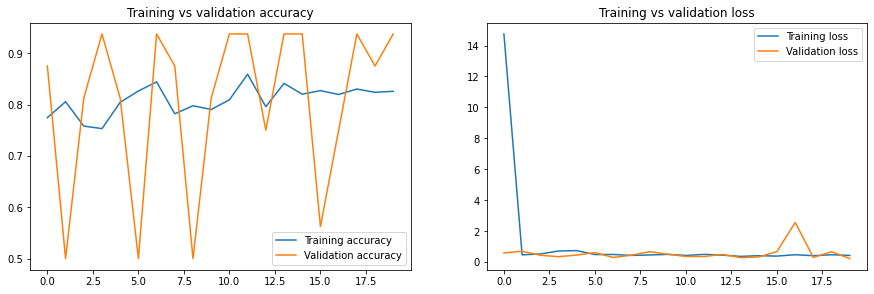

In [32]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")

plt.legend()
plt.title("Training vs validation loss")

plt.show()

# Saving the model